In [1]:
#importing packages

import sqlite3
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy.ma as ma
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from typing import Union
import joblib


In [2]:
### Exploring the SQLITE SCHEMA

# Connect to the SQLite database 
conn = sqlite3.connect('../db/data.db')

# Query to get the sqlite schema
sqlitemaster_query = "SELECT * FROM sqlite_master;"


# Read the sqlite schema into a DataFrame
sqlitemaster_df = pd.read_sql_query(sqlitemaster_query, conn)

display(sqlitemaster_df)

,type,name,tbl_name,rootpage,sql
0,table,homes,homes,2,"CREATE TABLE ""homes"" (\n""id"" TEXT,\n ""multipl..."
1,table,motion,motion,5,"CREATE TABLE ""motion"" (\n""id"" TEXT,\n ""home_i..."
2,table,final_table,final_table,14939,"CREATE TABLE ""final_table"" (\n""WC1"" REAL,\n ""..."


In [3]:
# Exploring Final table from SQLITE db
finaltb_query = "SELECT * FROM final_table;"

# Read the sqlite schema into a DataFrame
finaltb_df = pd.read_sql_query(finaltb_query, conn)

#finaltb_df = finaltb_df.set_index('id')
display(finaltb_df)

,WC1,bathroom1,bedroom1,conservatory,dining room,hallway,kitchen,living room,lounge,study,multiple_occupancy
0,0.0,2.0,0.0,0.0,0.0,1315.0,2125.0,0.0,0.0,0.0,0
1,0.0,609.0,1110.0,0.0,0.0,4156.0,4697.0,0.0,3299.0,1432.0,1
2,415.0,1349.0,1544.0,0.0,373.0,3877.0,3001.0,0.0,3758.0,1660.0,1
3,0.0,592.0,1363.0,0.0,0.0,510.0,3346.0,0.0,485.0,0.0,1
4,0.0,1546.0,359.0,0.0,0.0,191.0,0.0,0.0,4684.0,0.0,0
5,480.0,782.0,1702.0,3051.0,0.0,1237.0,3466.0,0.0,5473.0,0.0,1
6,0.0,0.0,1412.0,0.0,0.0,0.0,3753.0,0.0,2001.0,0.0,0
7,0.0,1875.0,4033.0,0.0,0.0,8220.0,6373.0,0.0,0.0,0.0,1
8,0.0,0.0,2151.0,0.0,0.0,1428.0,2958.0,0.0,840.0,0.0,0
9,7.0,797.0,1271.0,0.0,0.0,291.0,151.0,0.0,1993.0,0.0,0


### Splitting the data with features dataframe which is X and the labels column which is y. Decision Tree Classifier has been used because we are not using high dimensional data and the sample data points are also very less. Therefore, technique like neural networks will not be feasible. However, decision trees can be prune to the overfitting, so we reduce the complexity of the model by decreasing the number of dimensions further by considering the important features by decision trees. If we have more data, then we can increase the model complexity and use more number of the dimensions and use enhanced algorithms like random forests which works well on to the tabular data. 

In [4]:
X = finaltb_df.drop(['multiple_occupancy'], axis=1)
y = finaltb_df['multiple_occupancy']

In [5]:
# Define the parameter grid with several combinations of hyperp-parameters to tune the model's performance
param_grid = {
    'min_samples_leaf': [3,4, 5, 6, 8, 10],
    'max_leaf_nodes':[3,4, 6, 8, 10],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

#Stratified K fold has been used to split the data into 3 chunks based on the class sample proportions
cv = StratifiedKFold(n_splits=3)

#Performing hyper-parameter tuning by GridSearch Cross Validation to evaluate best model based on f1 score
clf = GridSearchCV(DecisionTreeClassifier(), 
                    param_grid=param_grid, cv = cv, scoring='f1')


In [6]:
# Fit the model on the data
#clf = DecisionTreeClassifier()
clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_leaf_nodes': [3, 4, 6, 8, 10],
                         'min_samples_leaf': [3, 4, 5, 6, 8, 10]},
             scoring='f1')

In [7]:
# To see the best parameters and the best score
print(f"Best parameters found: {clf.best_params_}")
print(f"Best F1 score: {clf.best_score_}")


Best parameters found: {'criterion': 'entropy', 'max_leaf_nodes': 3, 'min_samples_leaf': 4}
Best F1 score: 0.8221099887766554


In [8]:
# Access the best estimator and its feature importances
best_estimator = clf.best_estimator_
feature_importances = best_estimator.feature_importances_

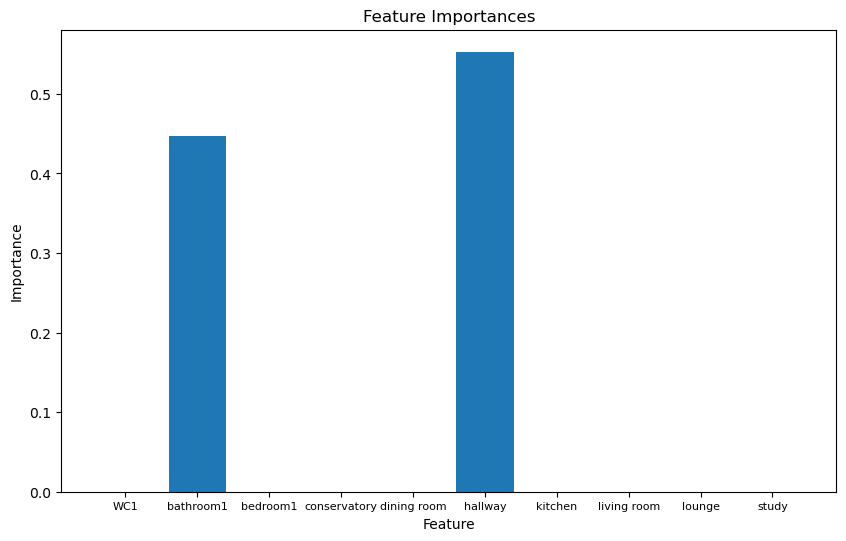

In [9]:
# Plot the histogram of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=X.columns)
plt.xlabel('Feature: Sensor Frequence to the locations')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(fontsize=8)  # Adjust the size here

plt.show()

### It is very surprising to see that the features like total sensor fequency to the locations like study and conservatory have not been considered by the Decision Tree because in the data analysis they seemed to suggest the strong indicator to the single occupants who don't have these locations.  

### Model is evaluated based on the F1 and Confusion Metrics due to the class imbalance issue. Accuracy may not be good metric alone due to class imbalance. 

In [10]:
def _print_results(clf, X : Union[pd.DataFrame, np.array], y:Union[pd.Series, np.array]) -> None:
    "Display Model performance"
    
    print("model accuracy score: %.3f" % clf.score(X, y))
    
    pred = clf.predict(X)
    print("model testing F1 score: %.3f" % f1_score(y, pred, average='weighted'))
    
    # Compute confusion matrix
    cm = confusion_matrix(y, pred, labels=best_estimator.classes_)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

model accuracy score: 0.853
model testing F1 score: 0.748


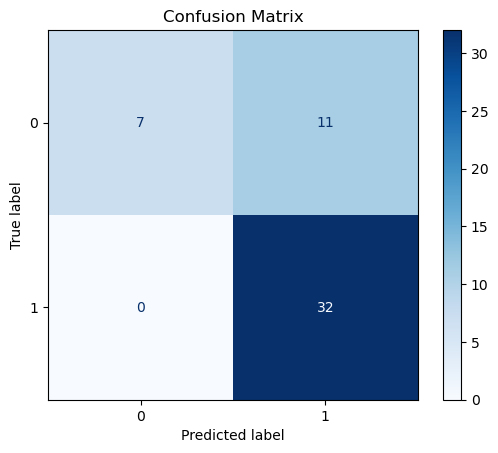

In [11]:
_print_results(clf, X, y)

### Using the best performing paramters along with the subset of the importance features to train the final ML model

In [12]:
clf2 = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes= 3, min_samples_leaf= 4)
clf2.fit(X[['bathroom1', 'hallway']], y)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=3,
                       min_samples_leaf=4)

model accuracy score: 0.853
model testing F1 score: 0.748


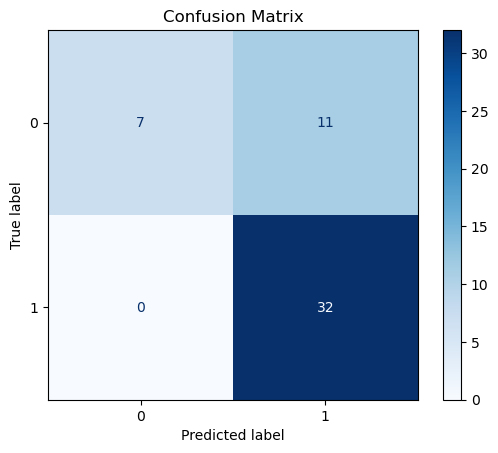

In [13]:
_print_results(clf, X, y)

### Model Serialization

In [175]:
# Save the model to a joblib 
joblib.dump(clf2, 'model.joblib')

['model.joblib']

In [196]:
# Load the model from the joblib
loaded_model = joblib.load('model.joblib')

# using the loaded model to predict
bathroom1_freq = 2
hallway_freq = 1315
features = pd.DataFrame([{'bathroom1': bathroom1_freq, 'hallway':hallway_freq}])

y_pred = loaded_model.predict(features)
print(y_pred)


[0]
